Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [2]:
from comet_ml import Experiment
import torch
import torchvision
import torchvision.transforms as transforms

train_portion = 0.7

#controllare che len(val) è len(train)

#hyperparameters
batch_size = 250

#pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12
pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization

root = './cifar100_data' #if not in lab
#root = '../datasets/cifar100'


dataset = torchvision.datasets.CIFAR100(root=root, train=True, transform=pad_totensor_transform, download=True)
train_subset, val_subset = torch.utils.data.random_split(dataset, [int(train_portion*len(dataset)), len(dataset) - int(train_portion*len(dataset))], generator=torch.Generator().manual_seed(1))
test_dataset = torchvision.datasets.CIFAR100(root=root, train=False, transform=pad_totensor_transform)


train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"BATCH SIZE: {batch_size}")
print(f"Tran subset len: {len(train_subset)}")
print(f"Tran loader len: {len(train_loader)}")
print(f"Test: {len(train_subset)/batch_size}")

print(f"Val subset len: {len(val_subset)}")
print(f"Val subset len: {len(val_loader)}")
print(f"Test: {len(val_subset)/batch_size}")


print(f"Test subset len: {len(test_dataset)}")
print(f"Test subset len: {len(test_loader)}")
print(f"Test: {len(test_dataset)/batch_size}")


Files already downloaded and verified
BATCH SIZE: 250
Tran subset len: 35000
Tran loader len: 140
Test: 140.0
Val subset len: 15000
Val subset len: 60
Test: 60.0
Test subset len: 10000
Test subset len: 40
Test: 40.0


torch.Size([250, 3, 32, 32]) torch.Size([250])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


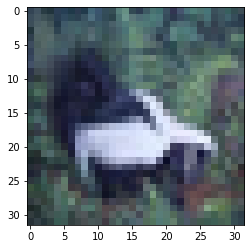

In [3]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

import matplotlib.pyplot as plt

img_sample = samples[0]
print(img_sample.shape)
print(img_sample.shape)
plt.imshow(img_sample.permute(1, 2, 0))
plt.show()

**Training loop**

In [4]:
#device

In [5]:
#!conda install einops
from mlp_mixer import *
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import json

In [6]:
def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted.cpu(), dim=1)
    return accuracy_score(predicted, true_labels.cpu()) #forse questi passaggi a cpu non sono molto efficienti..

def generate_folder():
    import time
    import os
    import os.path
    datetime = time.strftime("%Y%m%d-%H%M%S")

    folder = f"./models/{datetime}/"
    os.chdir(".")
    print("current dir is: %s" % (os.getcwd()))

    if os.path.isdir(folder):
        print("Exists")
    else:
        os.mkdir(folder)
    return folder

#def save_model(model, path):
#    filename = path + f"{filename}.pth"
#    print(filename)
#    torch.save(model.state_dict(), filename)    

In [7]:

experiment = Experiment(
    api_key="xX6qWBFbiOreu0W3IrO14b9nB",
    project_name="mlp-mixer",
    workspace="wedrid",
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_width_height = img_sample.shape[1]
patch_dims = 4
# variable_name = value #paper value
n_channels = 32 #128 #256 #100 #512 #embed dim
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
num_layers = 5 #8
mlp_dc_dimension = 128 #512 #1024 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = 32 #64 #128 #256 # ds è la dimensione del token mixing (il primo)

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension) #in this case 2 patches 16x16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-5) 

num_epochs = 500
steps_total = len(train_loader)

#ATTENZIONE: CAMBIARE IPERPARAMETRI ***PRIMAAAA*** DEL DICT SUCCESSIVO

hyper_params = {
    "dataset": root,
    "comment": 'added weight decay',
    "train_size": len(train_loader),
    "validation_size": len(val_loader),
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "steps": steps_total,
    "batch_size": batch_size,
    "image_width_and_height": image_width_height,
    "patch_width_and_height": patch_dims,
    "hidden_dim_size (n_channels)": n_channels,
    "number_of_layers": num_layers,
    "mlp_dc_dimension": mlp_dc_dimension,
    "mlp_ds_dimension": mlp_ds_dimension
}

experiment.log_parameters(hyper_params)
model_path = generate_folder()
with open(model_path+"/params.json", "w") as file:
    json.dump(hyper_params, file, indent=4)

model.to(device)
# training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_accuracy = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # [100, 3, 36, 36] is what is returned by iterator
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        predicted = model(images)
        loss = loss_func(predicted, labels)
        train_accuracy += get_accuracy(predicted, labels)

        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if False and (i+1) % 100:
            print(f'epoch: {epoch+1} of {num_epochs}, step {i+1} of {steps_total}, loss = {loss.item():.4f}')
    print(f"Loss of epoch {epoch+1}: {loss.item():.4f}")
    train_accuracy /= len(train_loader)
    #print(f"TRAIN LOADER LENGTH: {len(train_loader)}")
    experiment.log_metric("train epoch loss", loss.item(), step=epoch)
    experiment.log_metric("mean train epoch accuracy", train_accuracy, step=epoch)
    # validation
    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        temp = 0
        for i, (images, labels) in enumerate(tqdm(val_loader)): #numero esempi/batchsize TODO check
            # [100, 3, 36, 36] is what is returned by iterator
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, labels)
            val_accuracy += get_accuracy(predicted, labels)
        #print(f"Lenght val loader: {len(val_loader)}, counter: {temp}")
        val_accuracy /= len(val_loader) 
        experiment.log_metric("val epoch loss", loss.item(), step=epoch) #TODO average loss?
        experiment.log_metric("mean val epoch accuracy", val_accuracy, step=epoch)
    
    if epoch % 10 == 0:
        torch.save(model.state_dict(), model_path + f"checkpoint_epch_{epoch}.pth")
torch.save(model.state_dict(), model_path + f"final.pth")


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wedrid/mlp-mixer/da4a292d00c54710bcc6e21e3e000cec



current dir is: /Users/edrid/Desktop/Machine learning/Project/mlp_mixer


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 1: 4.1265


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 2: 3.7160


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 3: 3.5742


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 4: 3.4084


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 5: 3.2500


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 6: 3.0677


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 7: 3.0262


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 8: 2.8161


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 9: 2.8659


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 10: 2.7404


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 11: 2.7447


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 12: 2.4505


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 13: 2.6130


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 14: 2.7063


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 15: 2.4485


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 16: 2.3223


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 17: 2.3385


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 18: 2.3128


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 19: 2.1716


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 20: 2.2839


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 21: 2.1197


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 22: 2.0071


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 23: 2.0437


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 24: 1.9202


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 25: 2.0472


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 26: 1.9615


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 27: 1.9063


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 28: 1.8417


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 29: 1.9227


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 30: 1.8337


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 31: 1.9060


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 32: 1.8523


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 33: 1.8328


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 34: 1.6417


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 35: 1.7807


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 36: 1.6264


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 37: 1.5561


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 38: 1.5142


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 39: 1.7914


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 40: 1.7565


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 41: 1.4980


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 42: 1.4749


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 43: 1.3326


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 44: 1.3066


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 45: 1.3989


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 46: 1.4620


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 47: 1.4058


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 48: 1.3102


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 49: 1.2822


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 50: 1.2795


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 51: 1.3611


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 52: 1.2129


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 53: 1.3039


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 54: 1.3815


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 55: 1.3643


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 56: 1.2270


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 57: 1.1962


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 58: 1.3892


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 59: 1.2472


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 60: 1.0944


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 61: 1.1248


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 62: 1.0260


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 63: 1.0468


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 64: 1.1127


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 65: 0.8716


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 66: 1.0477


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 67: 1.1077


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 68: 0.9642


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 69: 1.1355


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 70: 0.9435


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 71: 1.1082


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 72: 1.0301


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 73: 1.0098


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 74: 1.0307


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 75: 0.9067


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 76: 1.1016


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 77: 0.8787


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 78: 1.0515


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 79: 1.0192


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 80: 0.8682


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 81: 0.8914


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 82: 0.6887


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 83: 0.8060


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 84: 0.8898


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 85: 0.9233


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 86: 0.7903


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 87: 0.9319


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 88: 0.8843


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 89: 0.8413


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 90: 0.7061


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 91: 0.7849


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 92: 0.8088


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 93: 0.7336


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 94: 0.7537


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 95: 0.7778


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 96: 0.9157


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 97: 0.7956


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 98: 0.6331


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 99: 0.8425


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 100: 0.7761


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 101: 0.7227


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 102: 0.6661


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 103: 0.8232


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 104: 0.7139


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 105: 0.5479


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 106: 0.5860


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 107: 0.6395


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 108: 0.6406


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 109: 0.7373


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 110: 0.9036


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 111: 0.7215


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 112: 0.6759


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 113: 0.7249


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 114: 0.6937


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 115: 0.6220


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 116: 0.6445


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 117: 0.5799


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 118: 0.4947


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 119: 0.5416


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 120: 0.6838


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 121: 0.6980


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 122: 0.6516


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 123: 0.6609


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 124: 0.6072


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 125: 0.6179


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 126: 0.5255


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 127: 0.5569


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 128: 0.5869


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 129: 0.5787


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 130: 0.5923


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 131: 0.5475


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 132: 0.5397


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 133: 0.5878


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 134: 0.5729


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 135: 0.6318


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 136: 0.5523


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 137: 0.4727


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 138: 0.4222


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 139: 0.5118


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 140: 0.5006


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 141: 0.4983


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 142: 0.5011


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 143: 0.5451


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 144: 0.6045


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 145: 0.5888


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 146: 0.4821


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 147: 0.5819


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 148: 0.5431


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 149: 0.5771


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 150: 0.4711


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 151: 0.5088


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 152: 0.5310


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 153: 0.4556


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 154: 0.6120


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 155: 0.5787


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 156: 0.5687


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 157: 0.4517


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 158: 0.5355


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 159: 0.4629


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 160: 0.5051


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 161: 0.5178


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 162: 0.5497


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 163: 0.3991


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 164: 0.5127


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 165: 0.4550


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 166: 0.4479


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 167: 0.5514


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 168: 0.4425


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 169: 0.4392


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 170: 0.3687


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 171: 0.4840


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 172: 0.5012


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 173: 0.5786


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 174: 0.4669


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 175: 0.4401


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 176: 0.4792


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 177: 0.3077


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 178: 0.5103


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 179: 0.4778


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 180: 0.4514


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 181: 0.4584


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 182: 0.4742


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 183: 0.4224


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 184: 0.4609


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 185: 0.4640


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 186: 0.3842


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 187: 0.4435


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 188: 0.3054


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 189: 0.3765


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 190: 0.4609


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 191: 0.3489


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 192: 0.3674


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 193: 0.4297


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 194: 0.3927


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 195: 0.3860


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 196: 0.4113


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 197: 0.4204


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 198: 0.3757


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 199: 0.4925


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 200: 0.4469


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 201: 0.3158


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 202: 0.3001


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 203: 0.2592


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 204: 0.3794


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 205: 0.4439


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 206: 0.4563


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 207: 0.4271


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 208: 0.3338


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 209: 0.2758


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 210: 0.3820


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 211: 0.4533


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 212: 0.3712


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 213: 0.4805


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 214: 0.4091


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 215: 0.3595


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 216: 0.3657


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 217: 0.3713


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 218: 0.4595


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 219: 0.4412


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 220: 0.4861


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 221: 0.2800


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 222: 0.3309


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 223: 0.3375


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 224: 0.3452


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 225: 0.4616


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 226: 0.4795


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 227: 0.3805


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 228: 0.3341


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 229: 0.3199


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 230: 0.3730


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 231: 0.3072


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 232: 0.3447


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 233: 0.3072


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 234: 0.3123


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 235: 0.3023


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 236: 0.5807


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 237: 0.2971


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 238: 0.3869


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 239: 0.2435


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 240: 0.3552


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 241: 0.3391


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 242: 0.2572


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 243: 0.2667


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 244: 0.2306


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 245: 0.3626


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 246: 0.3771


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 247: 0.3850


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 248: 0.3566


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 249: 0.2962


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 250: 0.2754


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 251: 0.4195


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 252: 0.3763


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 253: 0.3318


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 254: 0.3933


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 255: 0.5665


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 256: 0.4631


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 257: 0.2607


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 258: 0.3948


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 259: 0.2226


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 260: 0.2427


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 261: 0.2165


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 262: 0.3985


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 263: 0.3659


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 264: 0.3548


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 265: 0.3468


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 266: 0.1977


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 267: 0.2724


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 268: 0.1474


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 269: 0.2562


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 270: 0.4896


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 271: 0.6288


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 272: 0.5469


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 273: 0.4630


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 274: 0.2839


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 275: 0.2156


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 276: 0.2314


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 277: 0.2330


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 278: 0.2694


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 279: 0.3540


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 280: 0.3899


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 281: 0.4320


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 282: 0.2963


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 283: 0.3132


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 284: 0.2257


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 285: 0.2525


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 286: 0.2535


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 287: 0.2380


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 288: 0.2938


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 289: 0.2328


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 290: 0.2122


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 291: 0.2566


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 292: 0.2971


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 293: 0.2581


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 294: 0.2867


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 295: 0.2767


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 296: 0.3565


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 297: 0.3393


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 298: 0.3085


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 299: 0.2366


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 300: 0.2629


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 301: 0.1431


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 302: 0.1671


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 303: 0.1983


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 304: 0.4648


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 305: 0.3359


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 306: 0.2934


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 307: 0.2555


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 308: 0.2044


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 309: 0.1454


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 310: 0.1116


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 311: 0.1262


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 312: 0.1766


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 313: 0.4449


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 314: 0.6536


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 315: 0.2981


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 316: 0.2649


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 317: 0.1873


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 318: 0.1469


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 319: 0.0672


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 320: 0.0373


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 321: 0.0198


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 322: 0.0105


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 323: 0.0098


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 324: 0.0259


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 325: 0.0111


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 326: 0.0118


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 327: 0.0105


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 328: 0.0113


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 329: 0.0101


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 330: 0.0075


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 331: 0.0084


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 332: 0.0075


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 333: 0.0085


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 334: 0.0135


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 335: 2.9908


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 336: 1.0495


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 337: 0.6020


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 338: 0.2571


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 339: 0.1909


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 340: 0.1273


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 341: 0.1226


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 342: 0.0666


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 343: 0.0301


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 344: 0.0215


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 345: 0.0174


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 346: 0.0172


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 347: 0.0137


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 348: 0.0155


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 349: 0.0149


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 350: 0.0291


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 351: 0.0115


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 352: 0.0140


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 353: 0.0324


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 354: 2.8806


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 355: 1.1319


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 356: 0.4026


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 357: 0.2716


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 358: 0.2406


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 359: 0.1963


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 360: 0.1129


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 361: 0.2400


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 362: 0.2662


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 363: 0.4483


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 364: 0.5338


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 365: 0.3306


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 366: 0.2248


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 367: 0.1441


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 368: 0.1449


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 369: 0.1076


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 370: 0.0790


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 371: 0.0686


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 372: 0.0309


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 373: 0.0212


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 374: 0.0164


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 375: 0.0134


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 376: 0.0105


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 377: 0.0090


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 378: 0.0096


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 379: 0.0540


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 380: 0.0100


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 381: 0.0118


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 382: 0.0187


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 383: 2.2508


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 384: 0.8867


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 385: 0.3175


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 386: 0.2174


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 387: 0.1483


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 388: 0.1636


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 389: 0.2134


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 390: 0.1773


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 391: 0.2019


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 392: 0.4938


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 393: 0.5626


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 394: 0.4224


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 395: 0.2298


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 396: 0.1311


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 397: 0.0875


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 398: 0.0350


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 399: 0.0328


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 400: 0.0179


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 401: 0.0145


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 402: 0.0145


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 403: 0.0111


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 404: 0.0097


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 405: 0.0105


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 406: 0.0109


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 407: 0.0109


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 408: 0.0092


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 409: 0.0107


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 410: 0.0111


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 411: 0.0139


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 412: 1.3061


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 413: 1.0040


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 414: 0.4720


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 415: 0.3356


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 416: 0.1881


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 417: 0.1955


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 418: 0.1649


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 419: 0.3595


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 420: 0.2995


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 421: 0.3423


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 422: 0.2538


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 423: 0.2066


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 424: 0.1288


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 425: 0.1195


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 426: 0.1004


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 427: 0.1029


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 428: 0.1388


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 429: 0.5796


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 430: 0.5245


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 431: 0.2731


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 432: 0.2269


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 433: 0.0925


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 434: 0.0568


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 435: 0.0278


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 436: 0.0242


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 437: 0.0095


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 438: 0.0104


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 439: 0.0090


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 440: 0.0092


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 441: 0.0097


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 442: 0.0075


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 443: 0.0084


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 444: 0.0081


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 445: 0.0087


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 446: 0.0079


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 447: 0.0070


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 448: 0.0095


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 449: 0.0083


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 450: 2.6275


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 451: 0.9741


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 452: 0.4874


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 453: 0.1672


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 454: 0.1456


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 455: 0.1085


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 456: 0.1128


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 457: 0.1145


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 458: 0.1814


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 459: 0.4244


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 460: 0.5154


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 461: 0.3713


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 462: 0.1461


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 463: 0.1185


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 464: 0.0567


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 465: 0.0323


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 466: 0.0143


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 467: 0.0116


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 468: 0.0127


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 469: 0.0114


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 470: 0.0112


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 471: 0.0109


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 472: 0.0064


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 473: 0.0088


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 474: 0.0108


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 475: 0.0086


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 476: 0.0099


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 477: 0.0072


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 478: 0.0108


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 479: 2.8349


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 480: 0.8966


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 481: 0.4696


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 482: 0.2505


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 483: 0.1991


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 484: 0.1760


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 485: 0.1085


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 486: 0.1818


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 487: 0.3198


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 488: 0.4761


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 489: 0.2988


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 490: 0.2746


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 491: 0.1730


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 492: 0.0715


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 493: 0.0472


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 494: 0.0157


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 495: 0.0138


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 496: 0.0102


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 497: 0.0282


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 498: 0.0084


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 499: 0.0068


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 500: 0.0088


  0%|          | 0/60 [00:00<?, ?it/s]

In [8]:
if False: 
    examples = iter(train_loader)
    images, labels = examples.next()

    # metrics trial
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = loss_func(outputs, labels)

    #da mettere nel ciclo
    print(outputs.shape)

    #####
    predicted = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(predicted, labels)
    print(f'Accuracy {accuracy}')
    #####
    print(predicted.shape)
    print(predicted)
